### 1. Import Libraries and Fetch Data

In [138]:
import pandas as pd
from yahoo_fin import stock_info as si
from datetime import datetime, timedelta
from prophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import itertools

# Fetch historical data for the past two years up until 2024-02-09
end_date = datetime(2024, 2, 9)
start_date = end_date - timedelta(days=2*365)  # Approximately two years

# Get historical data for AAPL
data = si.get_data('AAPL', start_date=start_date, end_date=end_date)

# Reset index to have a column with dates and rename it to 'date'
data.reset_index(inplace=True)
data.rename(columns={'index': 'date'}, inplace=True)

display(data)


,date,open,high,low,close,adjclose,volume,ticker
0,2022-02-09,176.050003,176.649994,174.899994,176.279999,174.052185,71285000,AAPL
1,2022-02-10,174.139999,175.479996,171.550003,172.119995,169.944778,90865900,AAPL
2,2022-02-11,172.330002,173.080002,168.039993,168.639999,166.508743,98670700,AAPL
3,2022-02-14,167.369995,169.580002,166.559998,168.880005,166.745728,86185500,AAPL
4,2022-02-15,170.970001,172.949997,170.250000,172.789993,170.606308,62527400,AAPL
...,...,...,...,...,...,...,...,...
497,2024-02-02,179.860001,187.330002,179.250000,185.850006,185.361740,102518000,AAPL
498,2024-02-05,188.149994,189.250000,185.839996,187.679993,187.186920,69668800,AAPL
499,2024-02-06,186.860001,189.309998,186.770004,189.300003,188.802673,43490800,AAPL
500,2024-02-07,190.639999,191.050003,188.610001,189.410004,188.912384,53439000,AAPL


### 2. Calculate Technical Indicators - Feature Engineering

In [139]:
# Simple Moving Average (SMA)
data['SMA_10'] = data['close'].rolling(window=10).mean()

# Relative Strength Index (RSI)
delta = data['close'].diff(1)
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
data['RSI_14'] = 100 - (100 / (1 + rs))

# Bollinger Bands
data['20_SMA'] = data['close'].rolling(window=20).mean()
data['20_std'] = data['close'].rolling(window=20).std()
data['Upper_Band'] = data['20_SMA'] + (data['20_std'] * 2)
data['Lower_Band'] = data['20_SMA'] - (data['20_std'] * 2)

# Create lagged closing prices
data['Close_1'] = data['close'].shift(1)
data['Close_2'] = data['close'].shift(2)

# Drop rows with NaN values (due to shifting and rolling calculations)
data.dropna(inplace=True)

display(data)

,date,open,high,low,close,adjclose,volume,ticker,SMA_10,RSI_14,20_SMA,20_std,Upper_Band,Lower_Band,Close_1,Close_2
19,2022-03-09,161.479996,163.410004,159.410004,162.949997,160.890640,91454900,AAPL,163.156000,37.179469,166.169501,4.873161,175.915822,156.423179,157.440002,159.300003
20,2022-03-10,160.199997,160.389999,155.979996,158.520004,156.516647,105342000,AAPL,162.734000,36.439778,165.281501,4.540624,174.362748,156.200254,162.949997,157.440002
21,2022-03-11,158.929993,159.279999,154.500000,154.729996,152.774551,96970100,AAPL,161.721999,34.446900,164.412001,4.818695,174.049391,154.774611,158.520004,162.949997
22,2022-03-14,151.449997,154.119995,150.100006,150.619995,148.716507,108732100,AAPL,160.271999,33.509847,163.511001,5.606782,174.724565,152.297437,154.729996,158.520004
23,2022-03-15,150.899994,155.570007,150.380005,155.089996,153.130005,92964300,AAPL,159.460999,44.037340,162.821500,5.757663,174.336826,151.306175,150.619995,154.729996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,2024-02-02,179.860001,187.330002,179.250000,185.850006,185.361740,102518000,AAPL,190.703998,49.883308,188.155998,4.309938,196.775873,179.536123,186.860001,184.399994
498,2024-02-05,188.149994,189.250000,185.839996,187.679993,187.186920,69668800,AAPL,190.082997,56.857413,188.480998,3.989362,196.459721,180.502275,185.850006,186.860001
499,2024-02-06,186.860001,189.309998,186.770004,189.300003,188.802673,43490800,AAPL,189.494998,60.960283,188.667999,3.932484,196.532967,180.803030,187.679993,185.850006
500,2024-02-07,190.639999,191.050003,188.610001,189.410004,188.912384,53439000,AAPL,188.985999,51.600984,188.881499,3.845821,196.573140,181.189857,189.300003,187.679993


### 3. Prepare Data for Prophet

In [140]:
# Prepare the DataFrame for Prophet
data_prophet = data[['date', 'close', 'SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']].copy()
data_prophet.rename(columns={'date': 'ds', 'close': 'y'}, inplace=True)

# Normalize the additional regressors
data_prophet['SMA_10'] = (data_prophet['SMA_10'] - data_prophet['SMA_10'].mean()) / data_prophet['SMA_10'].std()
data_prophet['RSI_14'] = (data_prophet['RSI_14'] - data_prophet['RSI_14'].mean()) / data_prophet['RSI_14'].std()
data_prophet['Upper_Band'] = (data_prophet['Upper_Band'] - data_prophet['Upper_Band'].mean()) / data_prophet['Upper_Band'].std()
data_prophet['Lower_Band'] = (data_prophet['Lower_Band'] - data_prophet['Lower_Band'].mean()) / data_prophet['Lower_Band'].std()
data_prophet['Close_1'] = (data_prophet['Close_1'] - data_prophet['Close_1'].mean()) / data_prophet['Close_1'].std()
data_prophet['Close_2'] = (data_prophet['Close_2'] - data_prophet['Close_2'].mean()) / data_prophet['Close_2'].std()


### 4. Split Data into Training and Testing Sets

In [141]:
# Split the dataset into 80% training and 20% testing
train_size = int(len(data_prophet) * 0.8)
train = data_prophet[:train_size]
test = data_prophet[train_size:]
display(train.shape)
display(test.shape)

(386, 8)

(97, 8)

### 5. Hyperparameter Tuning

In [123]:
# Step 4: Hyperparameter Tuning
param_grid = {
    'changepoint_prior_scale': [0.03, 0.035, 0.04, 0.045, 0.05],
    'seasonality_prior_scale': [2.0, 2.25, 2.5, 2.75, 3.0]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []

for params in all_params:
    m = Prophet(**params)
    for col in ['SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']:
        m.add_regressor(col)
    m.fit(train)
    df_cv = cross_validation(m, initial='365 days', period='1 days', horizon='90 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    rmses.append(df_p['rmse'].mean())

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
best_params = tuning_results.loc[tuning_results['rmse'].idxmin()]
print("Best Parameters:", best_params)


18:58:33 - cmdstanpy - INFO - Chain [1] start processing
18:58:33 - cmdstanpy - INFO - Chain [1] done processing
18:58:51 - cmdstanpy - INFO - Chain [1] start processing
18:58:51 - cmdstanpy - INFO - Chain [1] done processing
18:59:10 - cmdstanpy - INFO - Chain [1] start processing
18:59:10 - cmdstanpy - INFO - Chain [1] done processing
18:59:29 - cmdstanpy - INFO - Chain [1] start processing
18:59:29 - cmdstanpy - INFO - Chain [1] done processing
18:59:49 - cmdstanpy - INFO - Chain [1] start processing
18:59:49 - cmdstanpy - INFO - Chain [1] done processing
19:00:08 - cmdstanpy - INFO - Chain [1] start processing
19:00:08 - cmdstanpy - INFO - Chain [1] done processing
19:00:27 - cmdstanpy - INFO - Chain [1] start processing
19:00:27 - cmdstanpy - INFO - Chain [1] done processing
19:00:46 - cmdstanpy - INFO - Chain [1] start processing
19:00:46 - cmdstanpy - INFO - Chain [1] done processing
19:01:05 - cmdstanpy - INFO - Chain [1] start processing
19:01:05 - cmdstanpy - INFO - Chain [1]

Best Parameters: changepoint_prior_scale    0.040000
seasonality_prior_scale    2.500000
rmse                       2.093659
Name: 12, dtype: float64


In [124]:
display(tuning_results)
tuning_results.to_csv('prophet_tuning_results_4.csv', index=False)

,changepoint_prior_scale,seasonality_prior_scale,rmse
0,0.030,2.00,2.130990
1,0.030,2.25,2.120057
2,0.030,2.50,2.121286
3,0.030,2.75,2.125614
4,0.030,3.00,2.127110
5,0.035,2.00,2.113031
6,0.035,2.25,2.109130
7,0.035,2.50,2.112114
8,0.035,2.75,2.112630
9,0.035,3.00,2.107946


### 6. Cross-Validation with Best Parameters

19:37:58 - cmdstanpy - INFO - Chain [1] start processing
19:37:58 - cmdstanpy - INFO - Chain [1] done processing


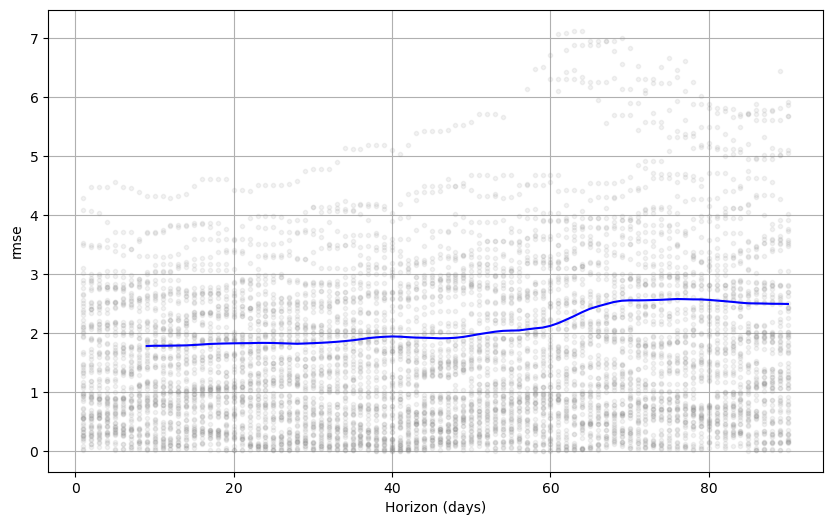

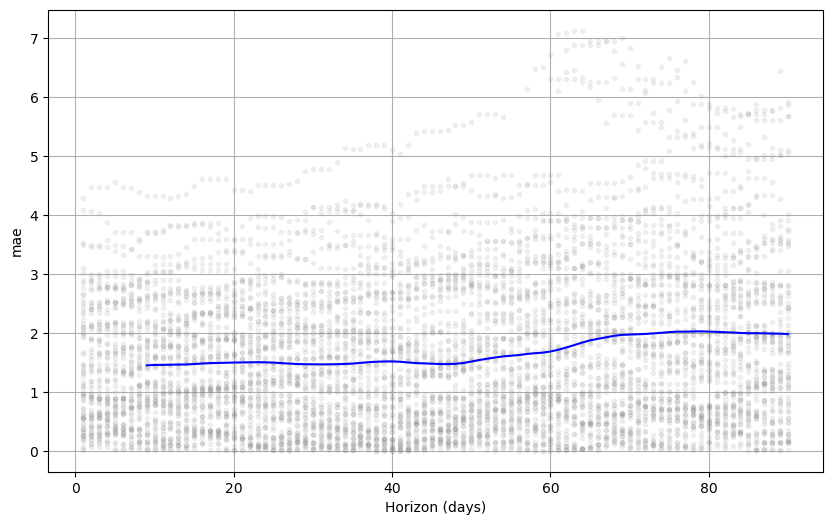

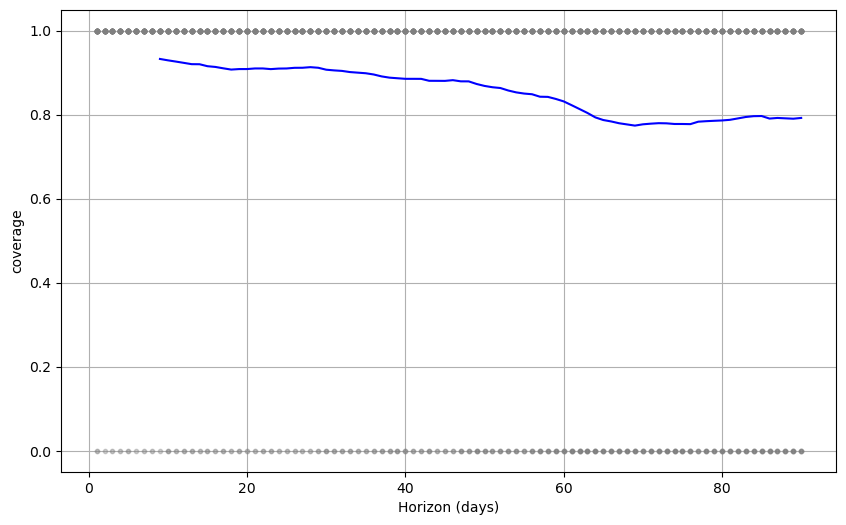

In [142]:
# model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'],
#                 seasonality_prior_scale=best_params['seasonality_prior_scale'])

model = Prophet(changepoint_prior_scale=0.05,
                seasonality_prior_scale=2.0)

for col in ['SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']:
    model.add_regressor(col)
model.fit(train)

cv_results = cross_validation(model, initial='365 days', period='1 days', horizon='90 days', parallel="processes")

# Plot RMSE
fig = plot_cross_validation_metric(cv_results, metric='rmse')
plt.show()

# Plot MAE
fig = plot_cross_validation_metric(cv_results, metric='mae')
plt.show()

# Plot coverage
fig = plot_cross_validation_metric(cv_results, metric='coverage')
plt.show()


### 7. Train the Prophet Model

In [143]:
# Step 7: Make Predictions
future = test[['ds']].copy()
for col in ['SMA_10', 'RSI_14', 'Upper_Band', 'Lower_Band', 'Close_1', 'Close_2']:
    future[col] = test[col]

forecast = model.predict(future)

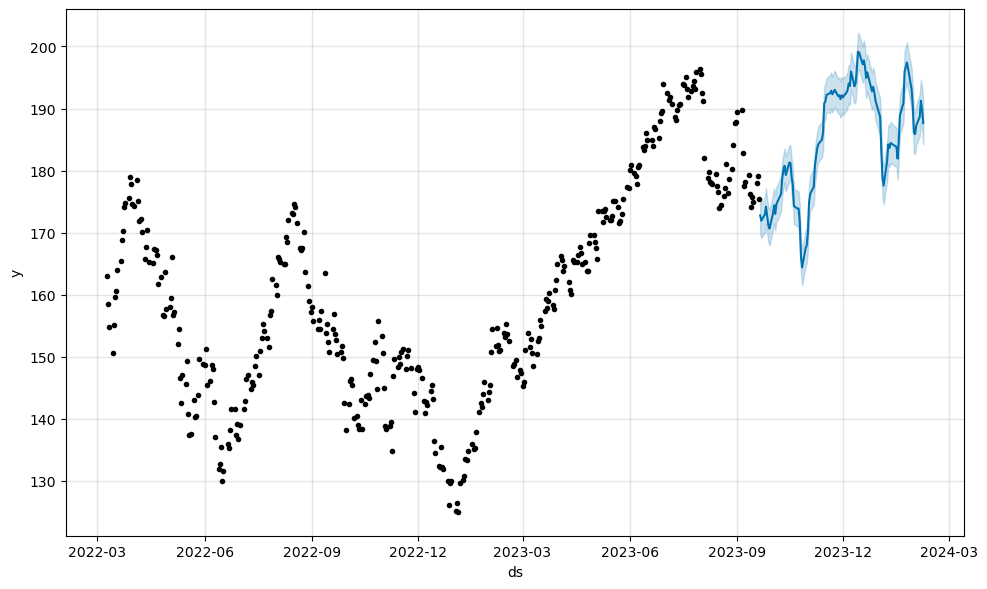

,ds,yhat,yhat_lower,yhat_upper,y
0,2023-09-21,172.764719,169.875996,175.707007,173.929993
1,2023-09-22,171.922826,169.133871,174.666995,174.789993
2,2023-09-25,172.910850,170.008142,175.718379,176.080002
3,2023-09-26,174.209528,171.387413,177.149035,171.960007
4,2023-09-27,172.695778,169.958543,175.454219,170.429993
...,...,...,...,...,...
92,2024-02-02,187.263138,184.188854,190.510345,185.850006
93,2024-02-05,188.663460,185.551861,192.333339,187.679993
94,2024-02-06,191.255340,187.786841,194.667582,189.300003
95,2024-02-07,189.841509,186.600222,193.368088,189.410004


In [144]:
# Plot the forecast
model.plot(forecast)
plt.show()

# Merge the forecast with actual values from the test dataset
merged_forecast = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].merge(test[['ds', 'y']], on='ds')

# Display the merged DataFrame
display(merged_forecast)

### 8. Evaluate the Model


In [145]:
y_true = test['y'].values
y_pred = forecast['yhat'].values

# Assuming y_true and y_pred are the actual and predicted values
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")

MAE: 1.6573448121100058
RMSE: 1.9874927427327844
R²: 0.943432818695411
MAPE: 0.9020927274473524


### 9. Results Visualisation

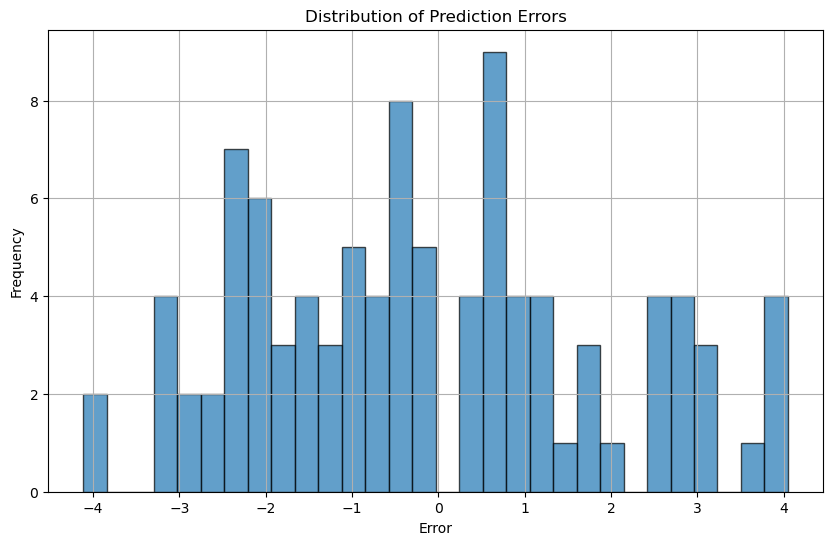

In [146]:
# Residuals
residuals = y_true - y_pred

# Residual Plot
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

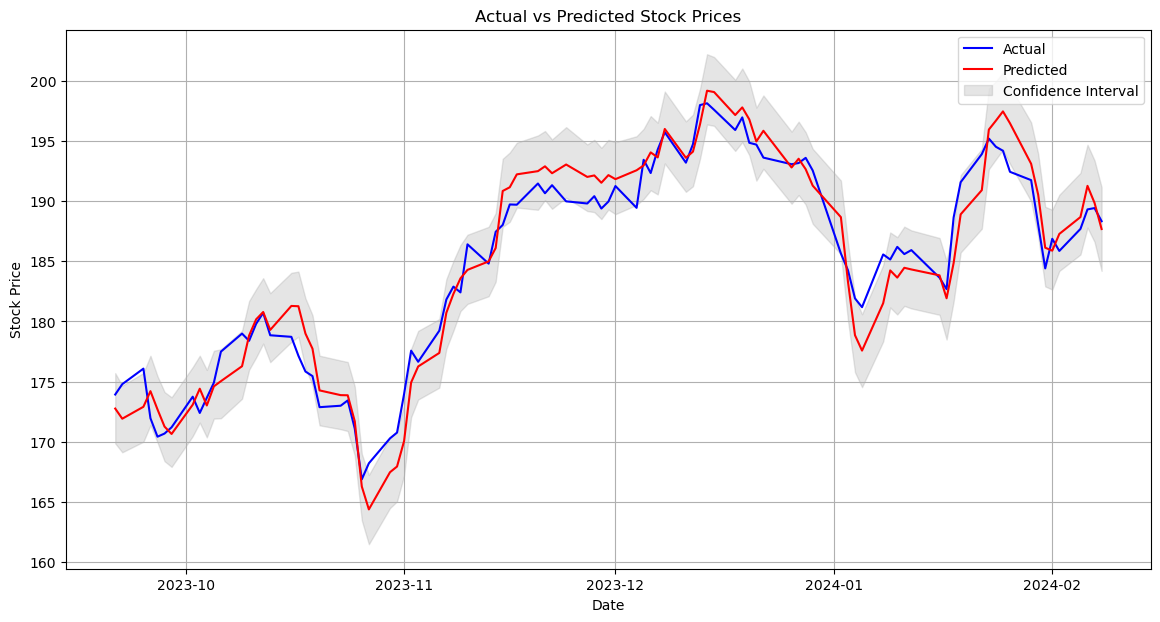

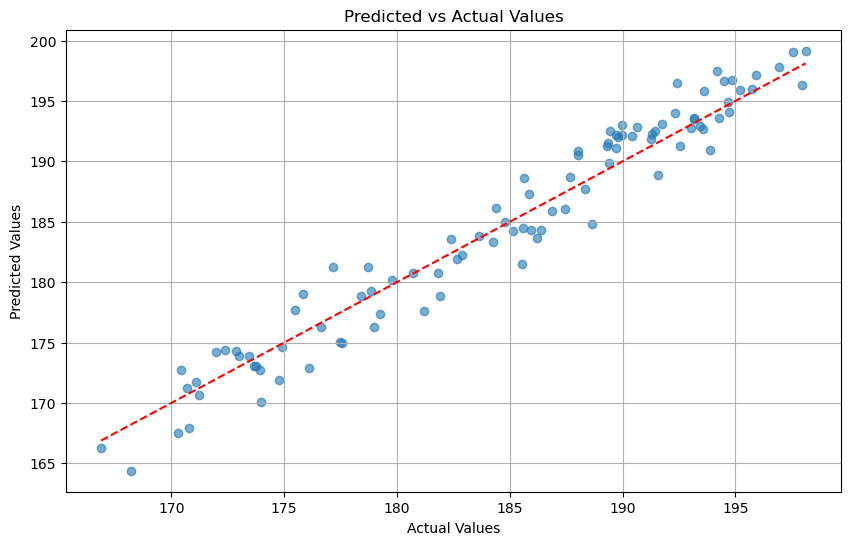

In [147]:
# Actual vs Predicted plot
plt.figure(figsize=(14, 7))
plt.plot(test['ds'], y_true, label='Actual', color='blue')
plt.plot(test['ds'], y_pred, label='Predicted', color='red')
plt.fill_between(test['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Confidence Interval')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.6)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--')
plt.title('Predicted vs Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()